In [1]:
import scanpy as sc
import pandas as pd
import harmonypy as hm

## Loading Data

In [2]:
# Path to the human data CSV file
human_data_path = "/Users/christinafourie/Desktop/beta_cell_analysis/data/human_islet/48d928d7-4657-4dc8-bade-f111380c3249/GSE85241_cellsystems_dataset_4donors_updated.csv.gz"

# Load CSV as DataFrame with tab as the delimiter
human_data = pd.read_csv(human_data_path, delimiter='\t', index_col=0)


# Transpose the DataFrame to have cells as rows and genes as columns
human_data_transposed = human_data.T

# Convert the transposed DataFrame to AnnData
human_islets = sc.AnnData(human_data_transposed)

# Display the structure of the loaded AnnData object
print("Human Islets Data Summary:")
print(human_islets)

Human Islets Data Summary:
AnnData object with n_obs × n_vars = 3072 × 19140


In [19]:
# Load SC-islet data from two files and concatenate them
sc_islet1_path = "/Users/christinafourie/Desktop/beta_cell_analysis/data/sc_islet/GSM5979665_scislet1.filtered_feature_bc_matrix.h5"
sc_islet2_path = "/Users/christinafourie/Desktop/beta_cell_analysis/data/sc_islet/GSM5979667_scislet2.filtered_feature_bc_matrix.h5"

In [20]:
sc_islet1 = sc.read_10x_h5(sc_islet1_path)
sc_islet2 = sc.read_10x_h5(sc_islet2_path)

/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Combining SC_Islet Data

In [22]:
# For sc_islet1
sc_islet1_df = pd.DataFrame(sc_islet1.X.toarray(), index=sc_islet1.obs_names, columns=sc_islet1.var_names)
sc_islet1_df = sc_islet1_df.T.groupby(level=0).mean().T  # Transpose, group by gene, and transpose back
sc_islet1 = sc.AnnData(sc_islet1_df)

# For sc_islet2
sc_islet2_df = pd.DataFrame(sc_islet2.X.toarray(), index=sc_islet2.obs_names, columns=sc_islet2.var_names)
sc_islet2_df = sc_islet2_df.T.groupby(level=0).mean().T  # Transpose, group by gene, and transpose back
sc_islet2 = sc.AnnData(sc_islet2_df)

In [31]:
adata_combined = sc.concat(
    [sc_islet1, sc_islet2],
    join='outer',
    label='batch',
    keys=['SC-Islet 1', 'SC-Islet 2'],
)

/opt/homebrew/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [34]:
# Convert to DataFrame for easier aggregation
adata_combined_df = pd.DataFrame(adata_combined.X, index=adata_combined.obs_names, columns=adata_combined.var_names)

# Aggregate duplicates by taking the mean of duplicated observations (cell names)
adata_combined_df = adata_combined_df.groupby(adata_combined_df.index).mean()

# Convert back to AnnData
adata_combined = sc.AnnData(adata_combined_df)

In [35]:
sc_islets = adata_combined

In [36]:
sc_islets

AnnData object with n_obs × n_vars = 20010 × 36591

## Preprocess Data

In [37]:
# Normalize the human islet data
sc.pp.normalize_total(human_islets, target_sum=1e4)
if human_islets.X.min() == 0:  # Apply log1p only if data is not log-transformed
    sc.pp.log1p(human_islets)
sc.pp.highly_variable_genes(human_islets, n_top_genes=2000)

# Normalize the stem cell-derived islet data
sc.pp.normalize_total(sc_islets, target_sum=1e4)
if sc_islets.X.min() == 0:  # Apply log1p only if data is not log-transformed
    sc.pp.log1p(sc_islets)
sc.pp.highly_variable_genes(sc_islets, n_top_genes=2000)

/opt/homebrew/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [38]:
# Remove the chromosome suffix from gene names in the human islets dataset
human_islets.var['clean_gene_names'] = human_islets.var_names.str.replace(r'__chr.*', '', regex=True)
human_islets.var_names = human_islets.var['clean_gene_names']  # Update gene names with cleaned names

# Display first few cleaned gene names to verify
print("Cleaned Human Islets Gene Names Sample:", human_islets.var_names[:5])

Cleaned Human Islets Gene Names Sample: Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1'], dtype='object', name='clean_gene_names')


In [39]:
# Convert the expression data in `human_islets` to a DataFrame
human_islets_df = pd.DataFrame(human_islets.X, index=human_islets.obs_names, columns=human_islets.var['clean_gene_names'].values)

# Transpose, group by gene names, and then transpose back
human_islets_df = human_islets_df.T.groupby(level=0).mean().T

# Convert back to AnnData
human_islets = sc.AnnData(human_islets_df)

In [40]:
# Find and subset to common genes
common_genes = human_islets.var_names.intersection(sc_islets.var_names)
print(common_genes)
human_islets = human_islets[:, common_genes]
sc_islets = sc_islets[:, common_genes]

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A4GALT',
       'A4GNT', 'AAAS', 'AACS',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B',
       'ZYX', 'ZZEF1'],
      dtype='object', length=16284)


In [41]:
# Concatenate datasets with batch labels
combined_islets = sc.concat([human_islets, sc_islets], label='batch', keys=['human', 'sc_derived'])

## Batch Correction

In [42]:
# Perform PCA for batch correction
sc.pp.pca(combined_islets)

In [43]:
# Run Harmony on the PCA embedding
harmony_out = hm.run_harmony(combined_islets.obsm['X_pca'], combined_islets.obs, 'batch')

# Store the corrected data in the obsm field
combined_islets.obsm['X_pca_harmony'] = harmony_out.Z_corr.T

2024-10-31 13:59:20,075 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-10-31 13:59:26,682 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-10-31 13:59:26,767 - harmonypy - INFO - Iteration 1 of 10
2024-10-31 13:59:29,962 - harmonypy - INFO - Iteration 2 of 10
2024-10-31 13:59:33,028 - harmonypy - INFO - Iteration 3 of 10
2024-10-31 13:59:36,273 - harmonypy - INFO - Iteration 4 of 10
2024-10-31 13:59:39,697 - harmonypy - INFO - Iteration 5 of 10
2024-10-31 13:59:42,078 - harmonypy - INFO - Iteration 6 of 10
2024-10-31 13:59:45,512 - harmonypy - INFO - Converged after 6 iterations


## UMAP

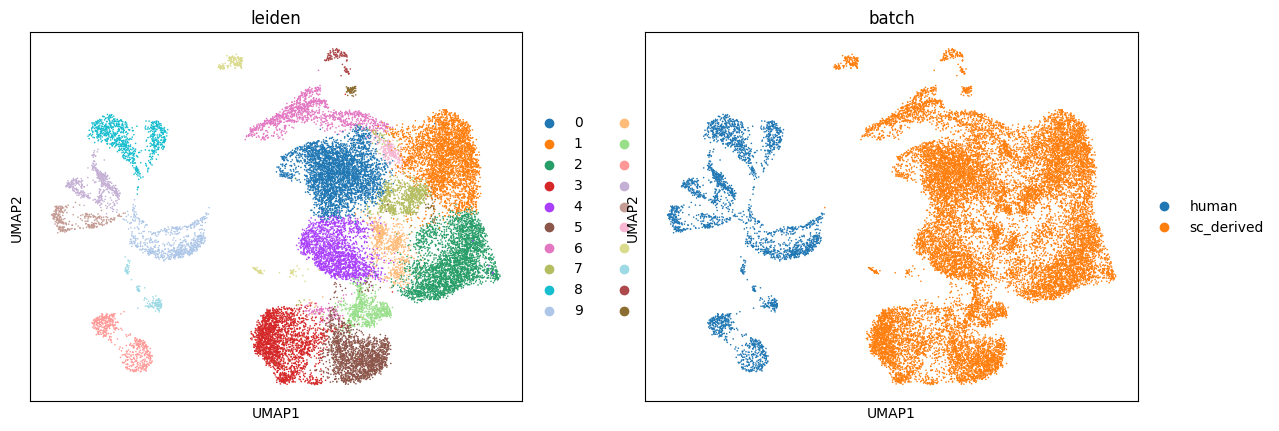

In [44]:
# Run clustering and UMAP
sc.pp.neighbors(combined_islets, use_rep='X_pca')
sc.tl.umap(combined_islets)
sc.tl.leiden(combined_islets, resolution=0.5)

# Plot UMAP with clusters and batch labels
sc.pl.umap(combined_islets, color=['leiden', 'batch'])

## DGE

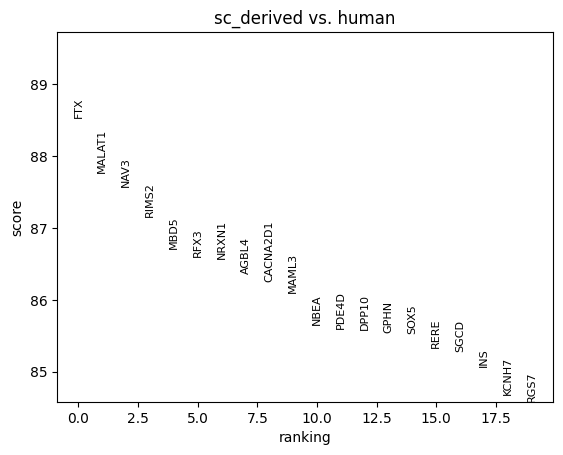

In [45]:
# Differential expression analysis
sc.tl.rank_genes_groups(combined_islets, 'batch', method='wilcoxon', reference='human')

# Plot top differentially expressed genes
sc.pl.rank_genes_groups(combined_islets, n_genes=20, sharey=False)

## Beta cell identification using markers

Markers present in the data: ['INS', 'PDX1', 'MAFA']


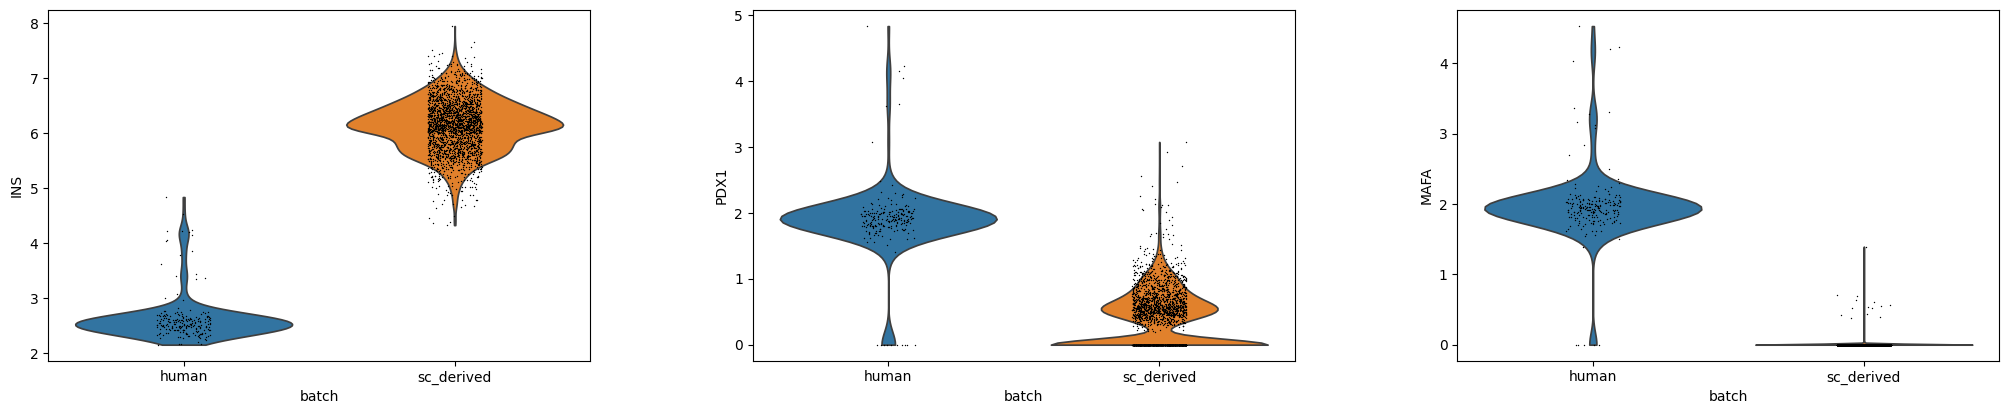

In [56]:
# Identify beta cell marker genes
beta_markers = ['INS', 'PDX1', 'MAFA']  # Add more markers if needed

# Check if the markers are in your dataset
present_markers = [gene for gene in beta_markers if gene in combined_islets.var_names]
print("Markers present in the data:", present_markers)

# Filter cells expressing high levels of beta cell markers
# Here, we use a threshold to identify cells expressing these markers
beta_cells = combined_islets[combined_islets[:, present_markers].X.mean(axis=1) > 2, :]

# Visualize or analyze the beta cells
sc.pl.violin(beta_cells, present_markers, groupby='batch')

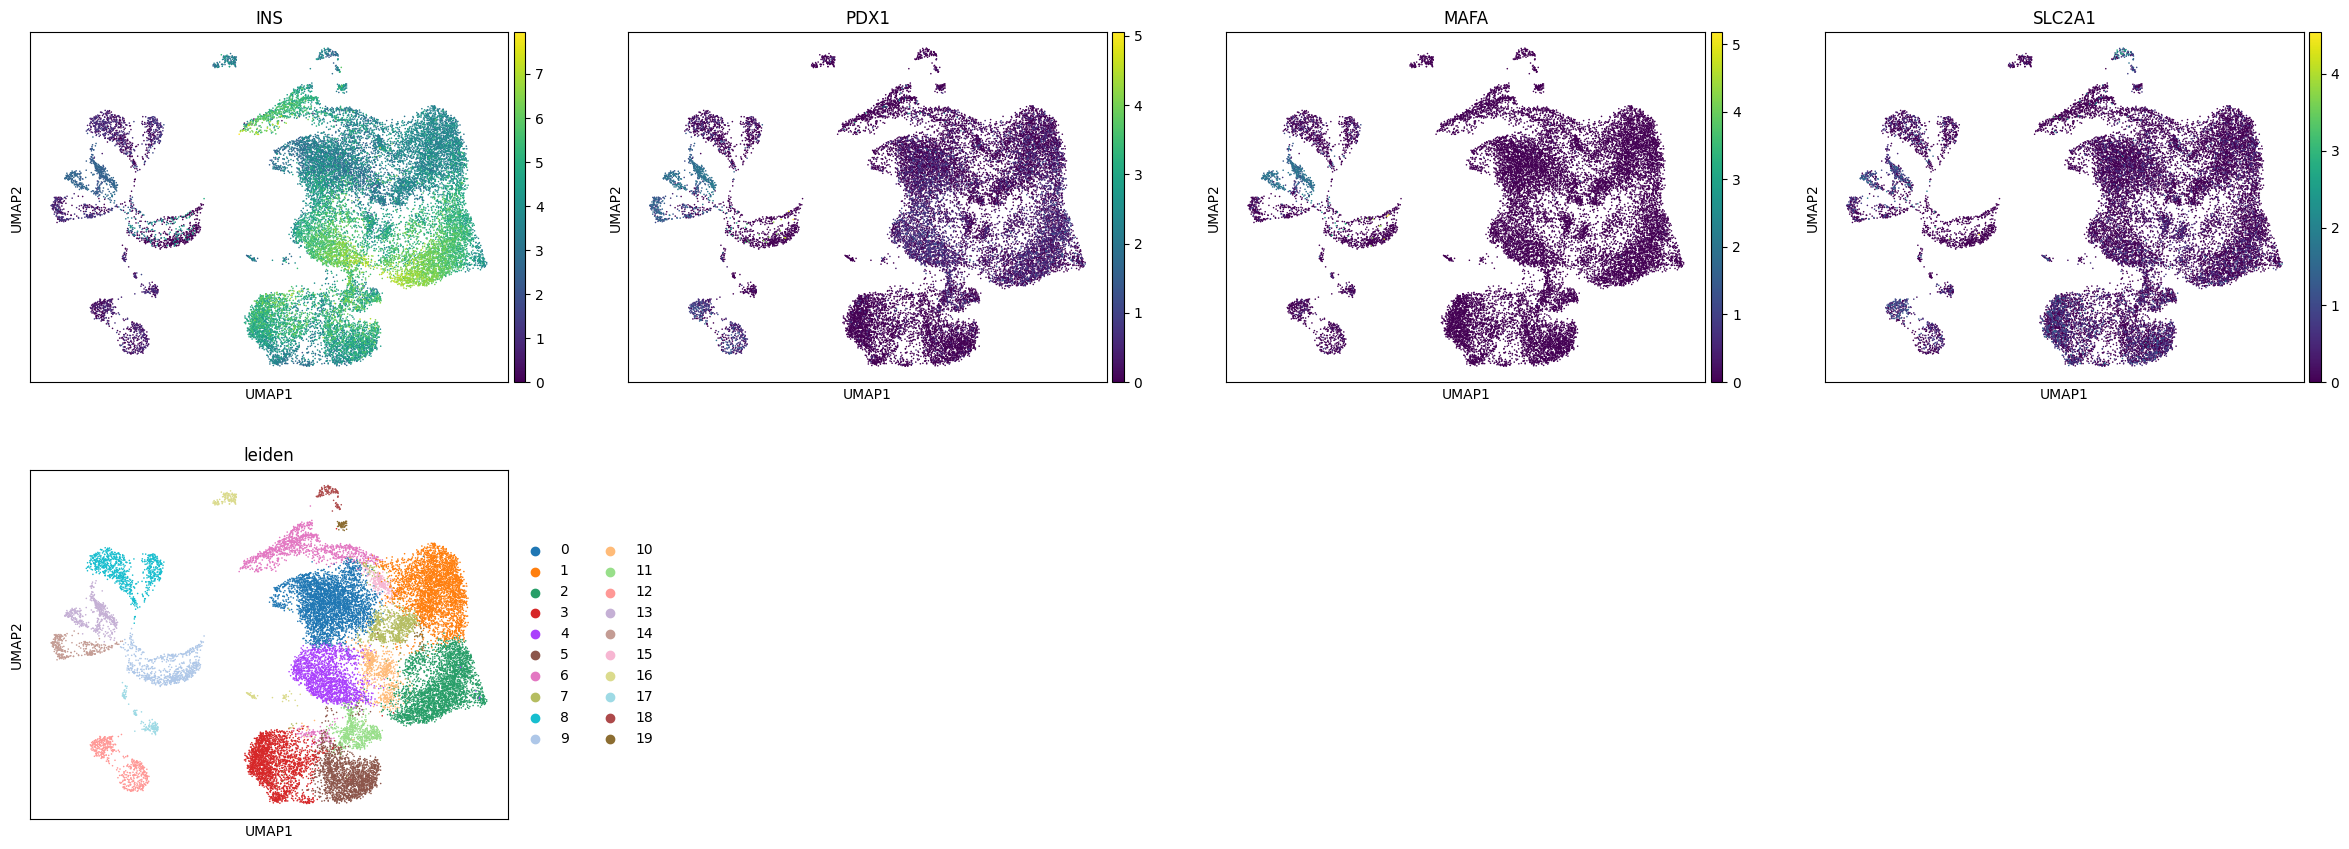

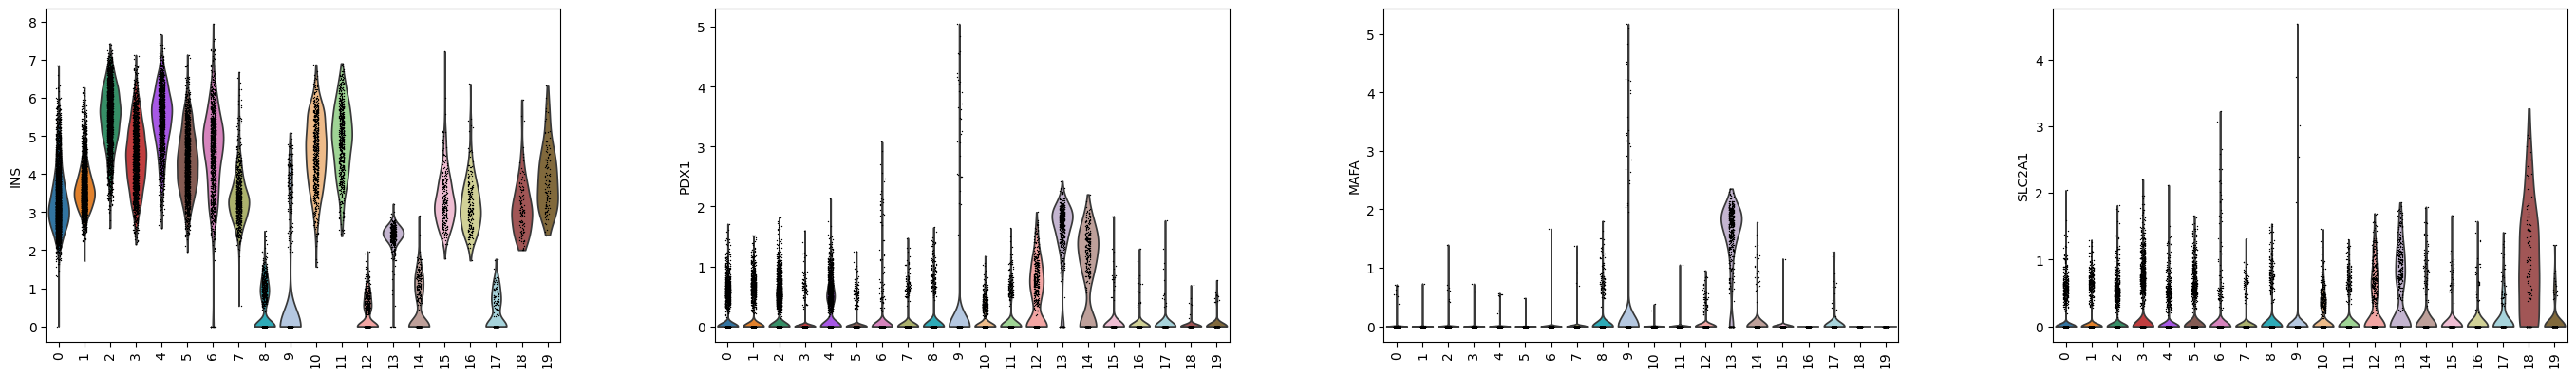

In [54]:
# Plot the expression of known beta cell markers across clusters
beta_markers = ['INS', 'PDX1', 'MAFA', 'SLC2A1']
sc.pl.umap(combined_islets, color=beta_markers + ['leiden'])  # Visualize clusters with beta cell markers

# Alternatively, use a violin plot to check marker expression by cluster
sc.pl.violin(combined_islets, keys=beta_markers, groupby='leiden', rotation=90)


/opt/homebrew/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


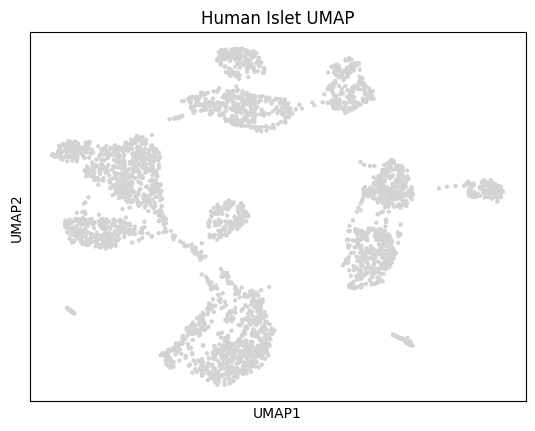

/opt/homebrew/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


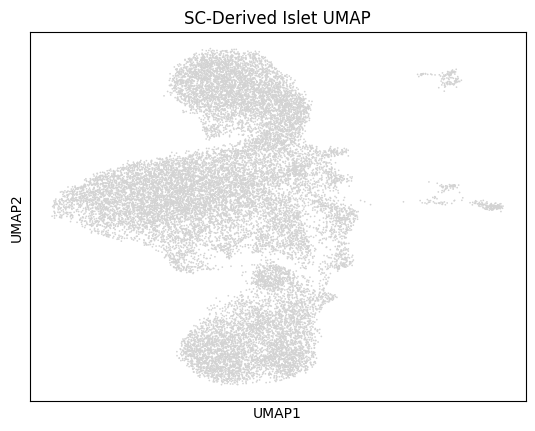

In [57]:
# Human Islet Data
sc.tl.pca(human_islets, svd_solver='arpack')
sc.pp.neighbors(human_islets, n_neighbors=10, n_pcs=20)  # Adjust n_neighbors and n_pcs as needed
sc.tl.umap(human_islets)
sc.pl.umap(human_islets, title="Human Islet UMAP")

# SC-Derived Islet Data
sc.tl.pca(sc_islets, svd_solver='arpack')
sc.pp.neighbors(sc_islets, n_neighbors=10, n_pcs=20)
sc.tl.umap(sc_islets)
sc.pl.umap(sc_islets, title="SC-Derived Islet UMAP")


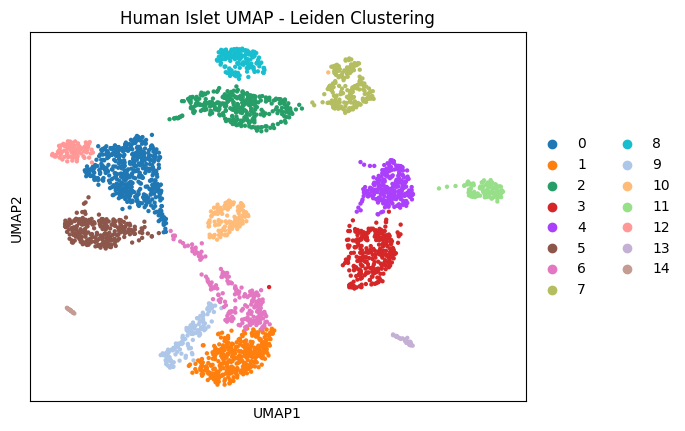

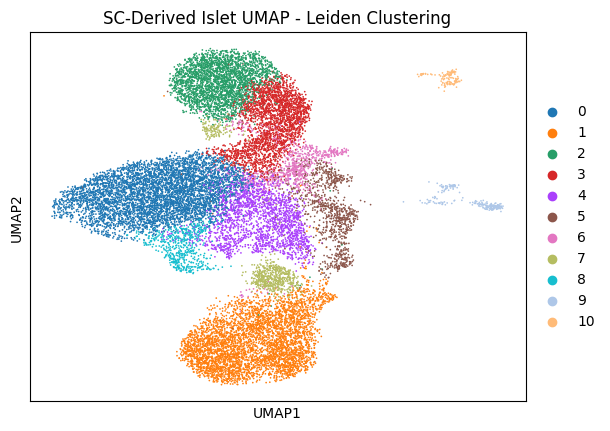

In [58]:
# Human Islet Data - Clustering
sc.tl.pca(human_islets, svd_solver='arpack')
sc.pp.neighbors(human_islets, n_neighbors=10, n_pcs=20)  # Adjust parameters as needed
sc.tl.leiden(human_islets, resolution=0.5)  # Use 'leiden' clustering; you can adjust resolution
sc.tl.umap(human_islets)
sc.pl.umap(human_islets, color='leiden', title="Human Islet UMAP - Leiden Clustering")

# SC-Derived Islet Data - Clustering
sc.tl.pca(sc_islets, svd_solver='arpack')
sc.pp.neighbors(sc_islets, n_neighbors=10, n_pcs=20)
sc.tl.leiden(sc_islets, resolution=0.5)
sc.tl.umap(sc_islets)
sc.pl.umap(sc_islets, color='leiden', title="SC-Derived Islet UMAP - Leiden Clustering")

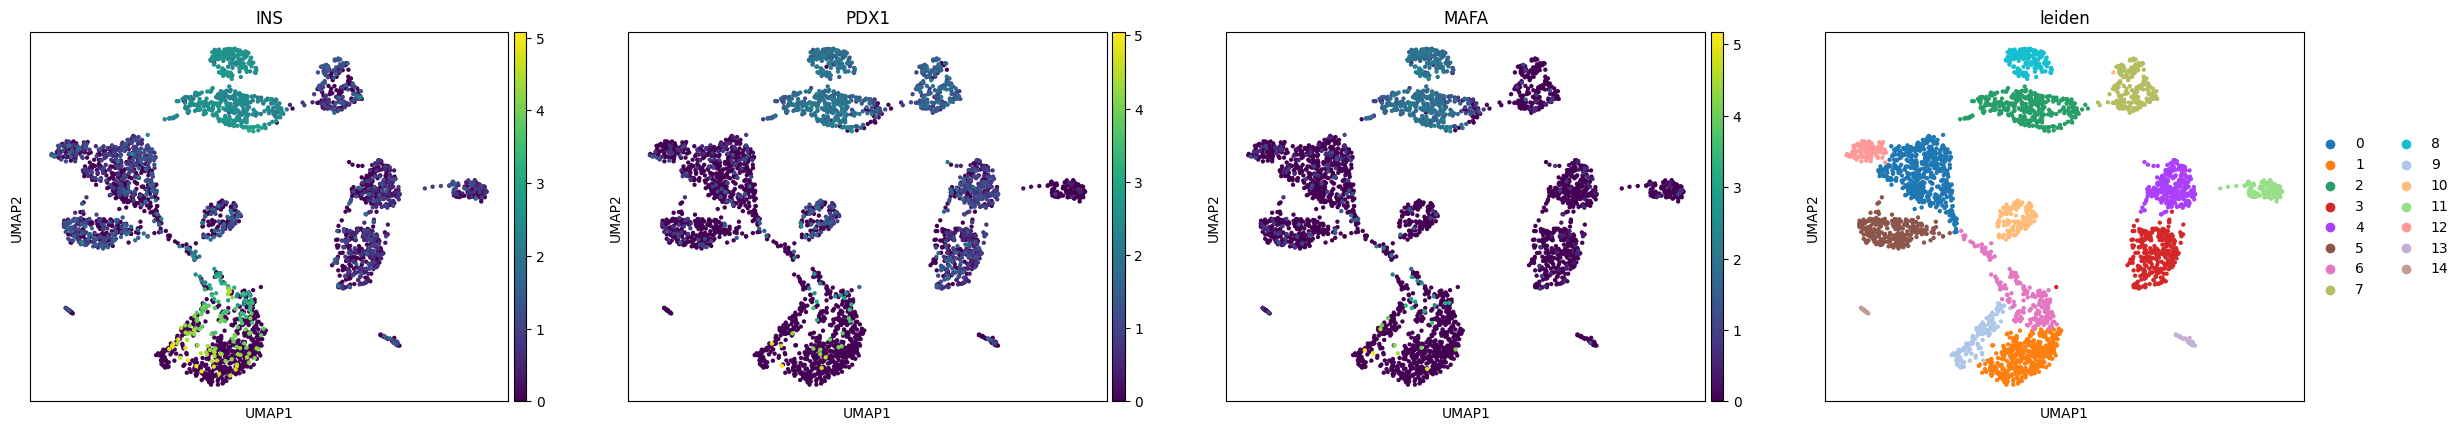

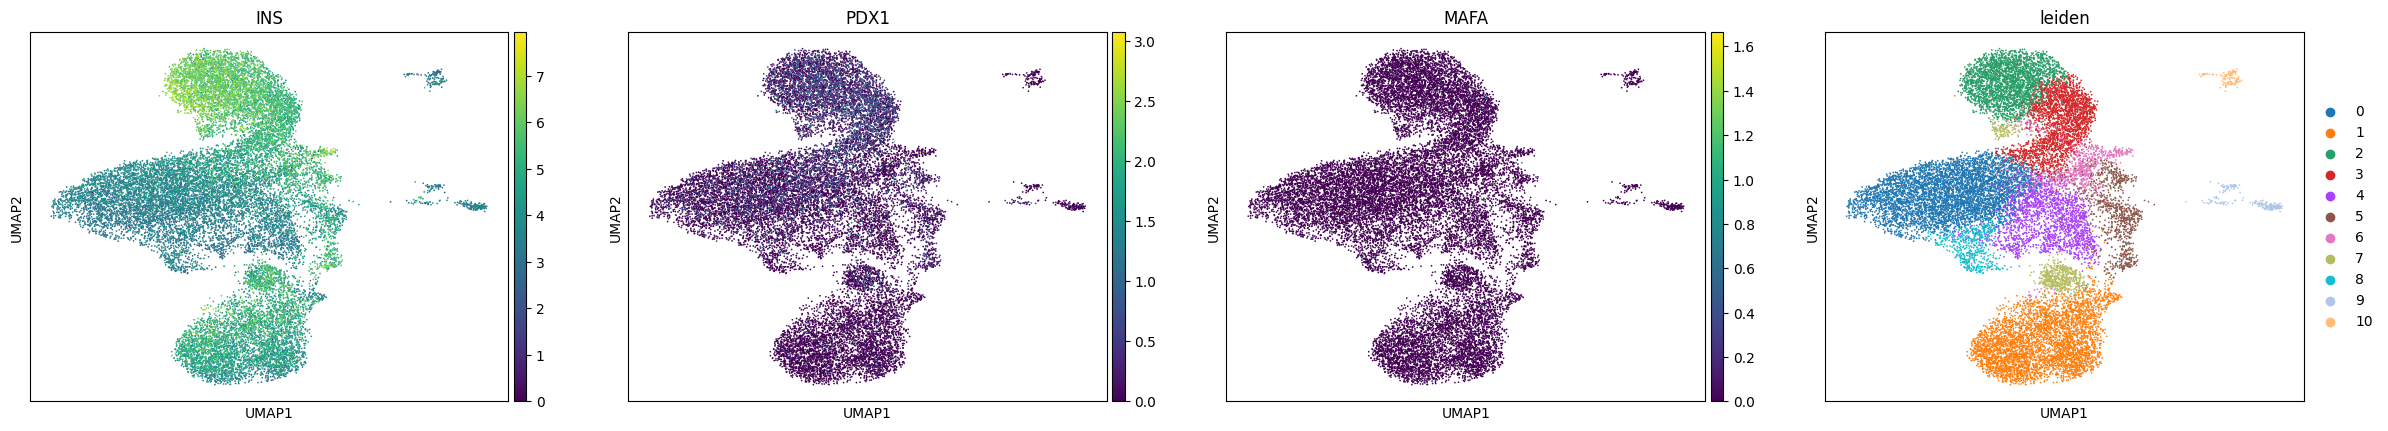

In [62]:
# Known beta cell markers
beta_markers = ['INS', 'PDX1', 'MAFA']

# Human Islet Data UMAP with Beta Markers
sc.pl.umap(human_islets, color=beta_markers + ['leiden'])

# SC-Derived Islet Data UMAP with Beta Markers
sc.pl.umap(sc_islets, color=beta_markers + ['leiden'])


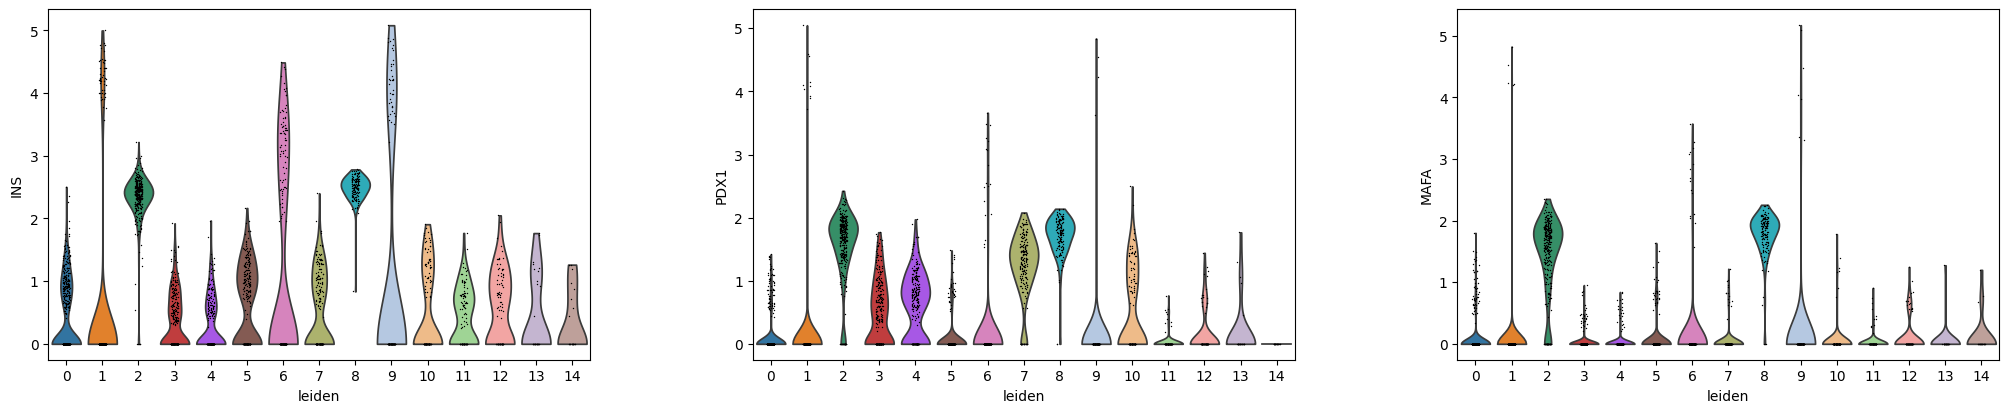

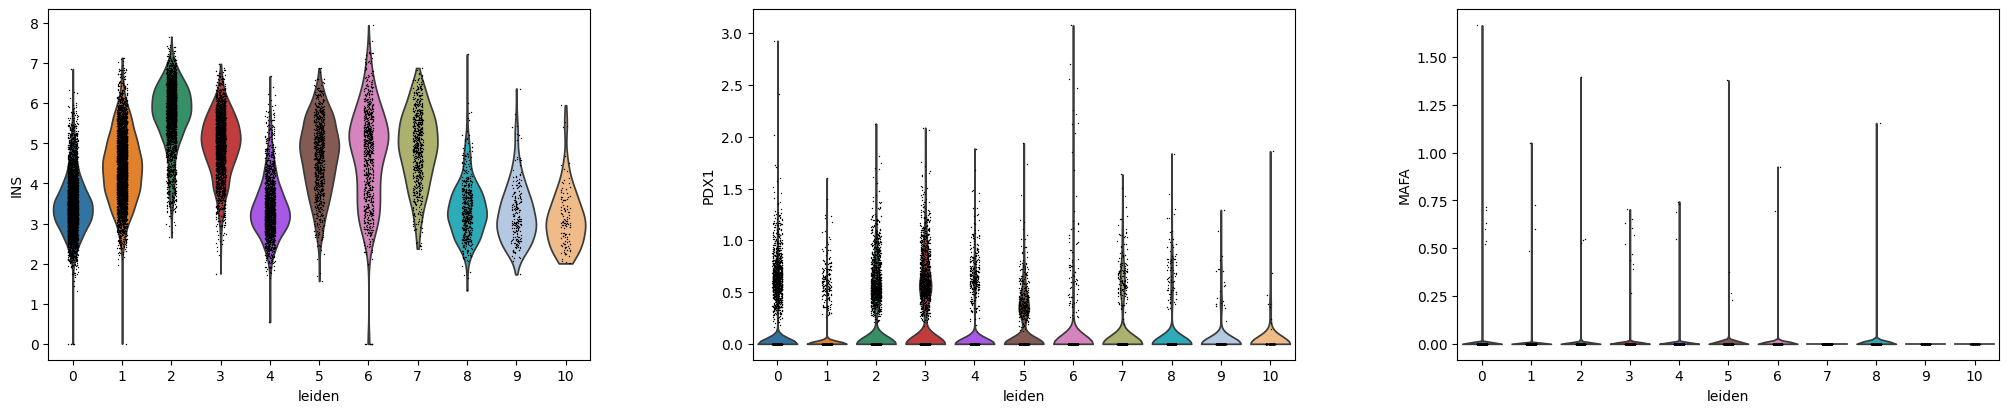

In [64]:
# Human Islet Data - Violin Plots for Beta Markers
sc.pl.violin(human_islets, keys=beta_markers, groupby='leiden',multi_panel=True)

# SC-Derived Islet Data - Violin Plots for Beta Markers
sc.pl.violin(sc_islets, keys=beta_markers, groupby='leiden', multi_panel=True)
